In [117]:
import pandas as pd
import numpy as np
import os
import yfinance as yf
import itertools
import warnings
import functions as func
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from scipy.stats import shapiro
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
from prophet import Prophet
from prophet.plot import plot, plot_components
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go
from statsmodels.stats.diagnostic import acorr_ljungbox
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [118]:
DATA_PATH = "nvda_data.json"

if os.path.exists(DATA_PATH):
    
    with open(DATA_PATH) as f:
        nvda_hist = pd.read_json(DATA_PATH)
else:
    nvda = yf.Ticker("NVDA")
    nvda_hist = nvda.history(period="max")

    nvda_hist.to_json(DATA_PATH)

In [167]:
df_nvda = func.calculate_technical_indicators(nvda_hist)
df_nvda.index = pd.to_datetime(df_nvda.index)
start_date = pd.Timestamp('2020-01-22 05:00:00')
df_nvda_2020 = df_nvda[df_nvda.index >= start_date]
df_nvda_2020

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ema_12,ema_26,macd_line,macd_signal,rsi
2020-01-22 05:00:00,62.194028,63.147757,62.004778,62.281185,23924000,0.0,0.0,61.130378,59.422451,1.707928,1.752482,69.491936
2020-01-23 05:00:00,62.682103,63.050645,61.793117,62.965981,24451600,0.0,0.0,61.412779,59.684935,1.727844,1.747554,67.921355
2020-01-24 05:00:00,64.121417,64.619447,61.830478,62.373329,37351200,0.0,0.0,61.560556,59.884075,1.676481,1.733340,70.781688
2020-01-27 05:00:00,59.325386,60.323936,57.828802,59.813454,47053600,0.0,0.0,61.291771,59.878844,1.412927,1.669257,53.571394
2020-01-28 05:00:00,60.473346,62.072023,59.940453,61.748302,31097600,0.0,0.0,61.362006,60.017322,1.344684,1.604342,58.227600
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-03 04:00:00,884.840027,903.739990,884.000000,889.640015,37006700,0.0,0.0,900.472060,867.487024,32.985035,43.675697,44.162626
2024-04-04 04:00:00,904.059998,906.340027,858.799988,859.049988,43496500,0.0,0.0,894.099433,866.862058,27.237375,40.388032,43.856582
2024-04-05 04:00:00,868.659973,884.809998,859.260010,880.080017,39885700,0.0,0.0,891.942600,867.841166,24.101433,37.130712,50.459906
2024-04-08 04:00:00,887.000000,888.299988,867.320007,871.330017,28322000,0.0,0.0,888.771433,868.099600,20.671833,33.838937,46.493006


In [168]:
nvda_hist_reset = nvda_hist.reset_index()
nvda_hist_reset = nvda_hist_reset.rename(columns={'index': 'ds', 'Close': 'y'})
nvda_prophet_data = nvda_hist_reset[['ds', 'y']].copy()
nvda_prophet_data['ds'] = pd.to_datetime(nvda_prophet_data['ds'])

print(nvda_prophet_data.head())

                   ds         y
0 1999-01-22 05:00:00  0.376237
1 1999-01-25 05:00:00  0.415653
2 1999-01-26 05:00:00  0.383404
3 1999-01-27 05:00:00  0.382210
4 1999-01-28 05:00:00  0.381015


In [169]:
nvda_prophet_data['ds'] = pd.to_datetime(nvda_prophet_data['ds'])
start_date = pd.Timestamp('2020-01-22 05:00:00')
nvda_prophet_2020 = nvda_prophet_data[nvda_prophet_data['ds'] >= start_date]

In [166]:
m = Prophet(weekly_seasonality=True)
m.fit(nvda_prophet_2020)

22:04:17 - cmdstanpy - INFO - Chain [1] start processing
22:04:18 - cmdstanpy - INFO - Chain [1] done processing


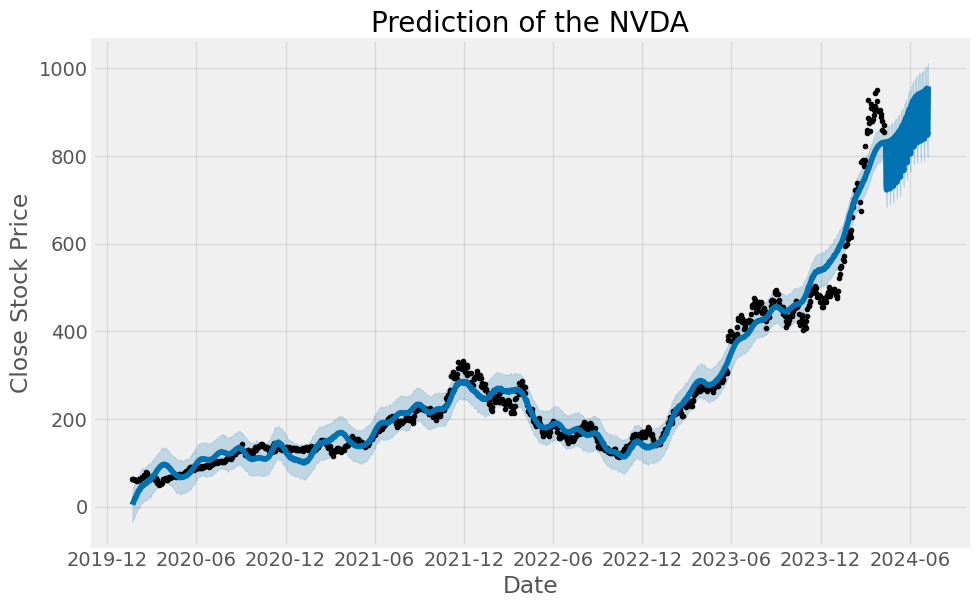

In [123]:
future = m.make_future_dataframe(periods=90)
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the NVDA")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

In [124]:
merged = prediction[['ds', 'yhat']].merge(nvda_prophet_2020, on='ds')
merged['residuals'] = merged['y'] - merged['yhat']
merged['error'] = np.abs(merged['yhat'] - merged['y'])
mae = merged['error'].mean()

merged['percentage_error'] = np.abs((merged['yhat'] - merged['y']) / merged['y'])
mape = merged['percentage_error'].mean() * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

MAE: 21.239831058390994
MAPE: 10.438555474626861%


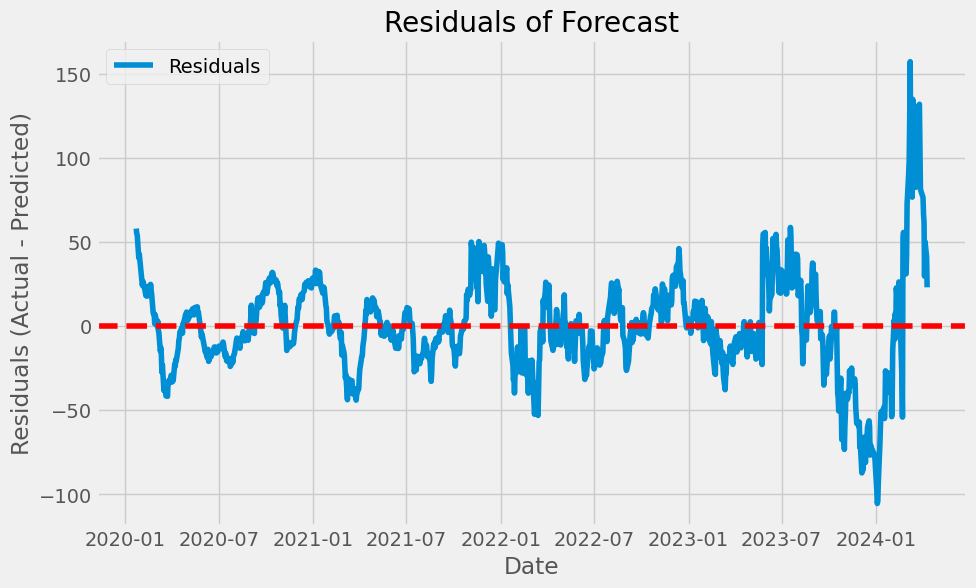

In [125]:
plt.figure(figsize=(10, 6))
plt.plot(merged['ds'], merged['residuals'], label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Forecast')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

The residuals look far from white noice, we need to fine tune the parameters.

# Hypertuning the parameters

In [31]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = [] 
mapes = []

for params in all_params:
    m = Prophet(**params).fit(nvda_prophet_2020) 
    df_cv = cross_validation(m, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])


tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

20:39:16 - cmdstanpy - INFO - Chain [1] start processing
20:39:16 - cmdstanpy - INFO - Chain [1] done processing
20:39:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:39:16 - cmdstanpy - INFO - Chain [1] start processing
20:39:18 - cmdstanpy - INFO - Chain [1] done processing
20:39:34 - cmdstanpy - INFO - Chain [1] start processing
20:39:35 - cmdstanpy - INFO - Chain [1] done processing
20:39:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:39:35 - cmdstanpy - INFO - Chain [1] start processing
20:39:37 - cmdstanpy - INFO - Chain [1] done processing
20:39:51 - cmdstanpy - INFO - Chain [1] start processing
20:39:51 - cmdstanpy - INFO - Chain [1] done processing
20:39:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

In [170]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}


In [127]:
m = Prophet(interval_width=0.95, weekly_seasonality=True,
            changepoint_prior_scale=best_params['changepoint_prior_scale'],
            seasonality_prior_scale=best_params['seasonality_prior_scale'])
model = m.fit(nvda_prophet_2020)

21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] done processing


In [128]:
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

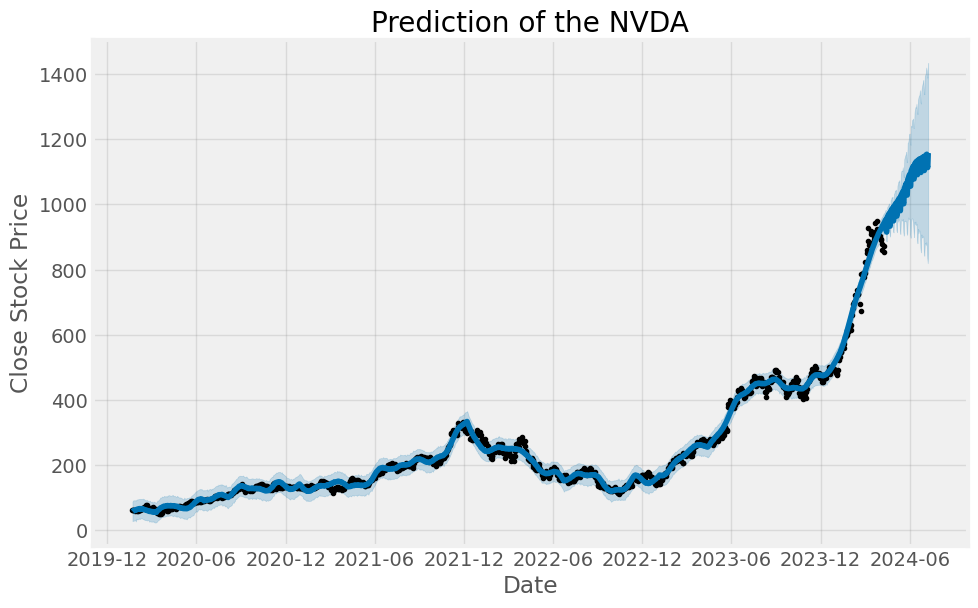

In [129]:
m.plot(forecast)
plt.title("Prediction of the NVDA")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
# ax.set_xlim(pd.Timestamp('2024-01-01'), forecast['ds'].max())
plt.show()

In [130]:
merged_data = forecast[['ds', 'yhat']].merge(nvda_prophet_2020, on='ds')
merged_data['residuals'] = merged_data['y'] - merged_data['yhat']
merged_data['error'] = np.abs(merged_data['yhat'] - merged_data['y'])
mae = merged_data['error'].mean()

merged_data['percentage_error'] = np.abs((merged_data['yhat'] - merged_data['y']) / merged_data['y'])
mape = merged_data['percentage_error'].mean() * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

MAE: 11.451031086805518
MAPE: 5.619745253624611%


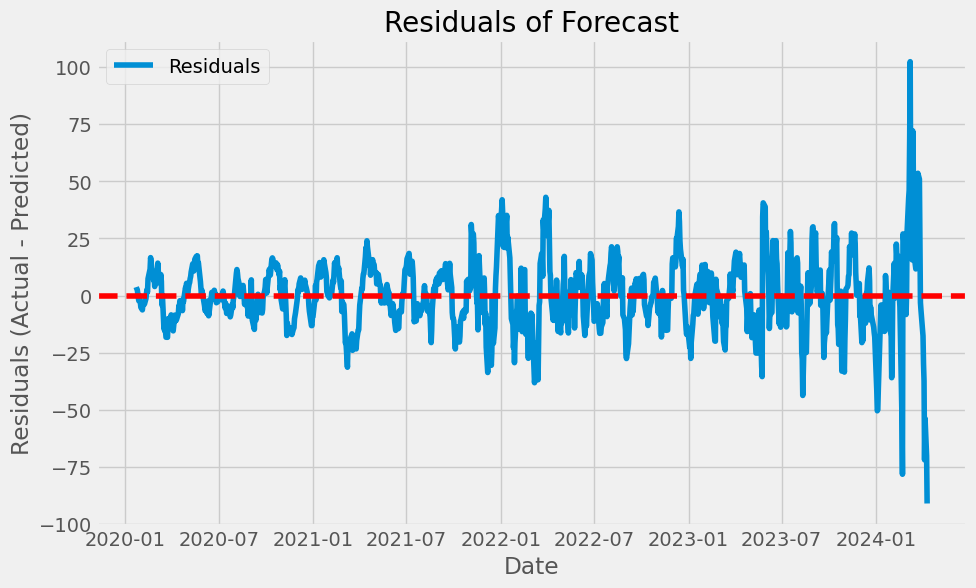

In [131]:
plt.figure(figsize=(10, 6))
plt.plot(merged_data['ds'], merged_data['residuals'], label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Forecast')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

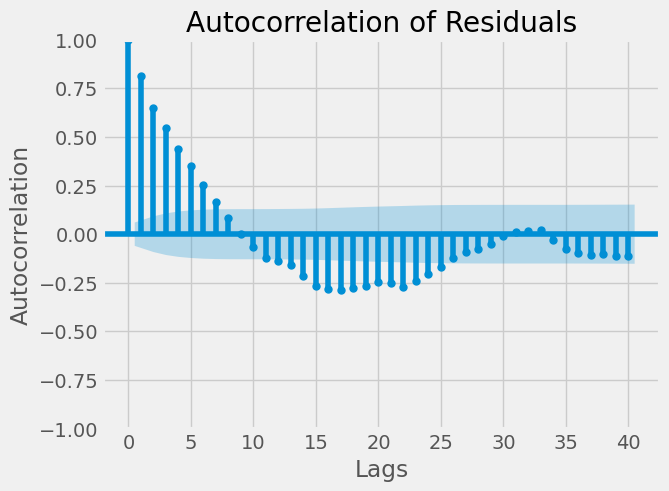

In [132]:
plot_acf(merged_data['residuals'], lags=40, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [133]:
stat, p = shapiro(merged_data['residuals'].dropna())
print('Shapiro-Wilk Test: Stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

Shapiro-Wilk Test: Stat=0.954, p=0.000
Probably not Gaussian


In [134]:
lb_test = acorr_ljungbox(merged_data['residuals'], lags=[10, 20], return_df=True)
lb_test

,lb_stat,lb_pvalue
10,1918.130880,0.0
20,2508.526977,0.0


The significant autocorrelation in the residuals indicates that the Prophet model has not captured all the underlying patterns in the data.

## Try boxcox transformation

In [140]:
df_boxcox = nvda_prophet_2020.copy()
data_transformed, best_lambda = stats.boxcox(df_boxcox['y'])
df_boxcox['y_transformed'] = data_transformed
df_boxcox = df_boxcox.drop(columns=['y'])
df_boxcox = df_boxcox.rename(columns={'y_transformed': 'y'})

In [141]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

all_params_box = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes_box = [] 
mapes_box = []

for params in all_params_box:
    m = Prophet(**params).fit(df_boxcox) 
    df_cv_box = cross_validation(m, horizon='90 days', parallel="processes")
    df_p_box = performance_metrics(df_cv_box, rolling_window=1)
    maes_box.append(df_p_box['mae'].values[0])
    mapes_box.append(df_p_box['mape'].values[0])


tuning_results_box = pd.DataFrame(all_params_box)
tuning_results_box['mae'] = maes_box
tuning_results_box['mape'] = mapes_box

21:32:18 - cmdstanpy - INFO - Chain [1] start processing
21:32:18 - cmdstanpy - INFO - Chain [1] done processing
21:32:25 - cmdstanpy - INFO - Chain [1] start processing
21:32:25 - cmdstanpy - INFO - Chain [1] done processing
21:32:32 - cmdstanpy - INFO - Chain [1] start processing
21:32:32 - cmdstanpy - INFO - Chain [1] done processing
21:32:39 - cmdstanpy - INFO - Chain [1] start processing
21:32:39 - cmdstanpy - INFO - Chain [1] done processing
21:32:44 - cmdstanpy - INFO - Chain [1] start processing
21:32:45 - cmdstanpy - INFO - Chain [1] done processing
21:32:53 - cmdstanpy - INFO - Chain [1] start processing
21:32:53 - cmdstanpy - INFO - Chain [1] done processing
21:33:02 - cmdstanpy - INFO - Chain [1] start processing
21:33:02 - cmdstanpy - INFO - Chain [1] done processing
21:33:11 - cmdstanpy - INFO - Chain [1] start processing
21:33:11 - cmdstanpy - INFO - Chain [1] done processing
21:33:20 - cmdstanpy - INFO - Chain [1] start processing
21:33:21 - cmdstanpy - INFO - Chain [1]

In [143]:
best_params_box = all_params_box[np.argmin(mapes_box)]
print(best_params_box)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


In [145]:
m_box = Prophet(interval_width=0.95, weekly_seasonality=True,
            changepoint_prior_scale=best_params_box['changepoint_prior_scale'],
            seasonality_prior_scale=best_params_box['seasonality_prior_scale'])
model = m_box.fit(df_boxcox)

21:39:18 - cmdstanpy - INFO - Chain [1] start processing
21:39:18 - cmdstanpy - INFO - Chain [1] done processing


In [149]:
from scipy.special import inv_boxcox
future_box = m_box.make_future_dataframe(periods=90)
forecast_box = m_box.predict(future_box)
forecast_box['yhat_original_scale'] = inv_boxcox(forecast_box['yhat'], best_lambda)

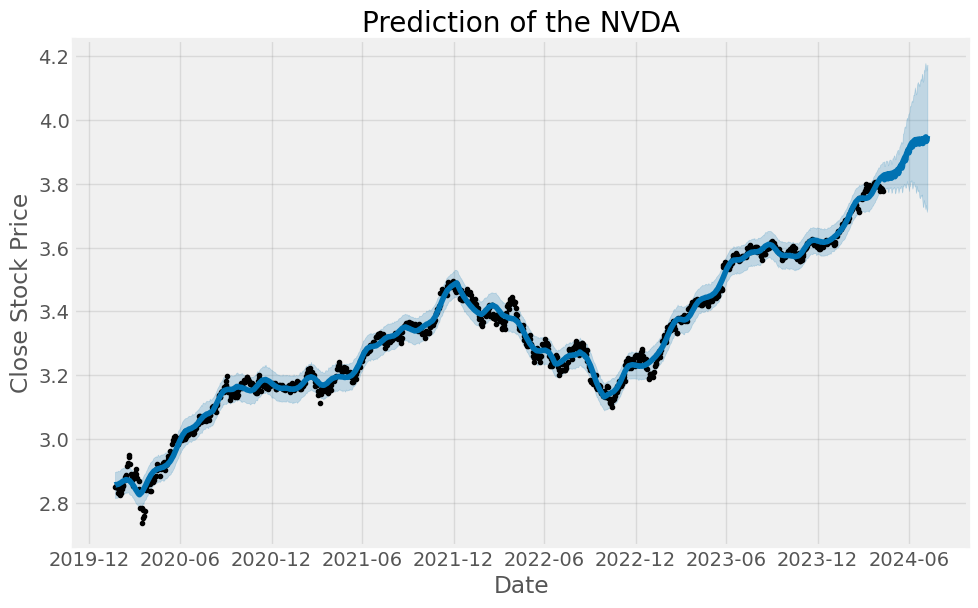

In [154]:
m_box.plot(forecast_box)
plt.title("Prediction of the NVDA")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

In [159]:
merged_box = forecast_box[['ds', 'yhat_original_scale']].merge(nvda_prophet_2020, on='ds')
merged_box['residuals'] = merged_box['y'] - merged_box['yhat_original_scale']
merged_box['error'] = np.abs(merged_box['yhat_original_scale'] - merged_box['y'])
mae_box = merged_box['error'].mean()

merged_box['percentage_error'] = np.abs((merged_box['yhat_original_scale'] - merged_box['y']) / merged_box['y'])
mape_box = merged_box['percentage_error'].mean() * 100

print(f"MAE: {mae_box}")
print(f"MAPE: {mape_box}%")

MAE: 11.311581323364523
MAPE: 4.530971376908313%


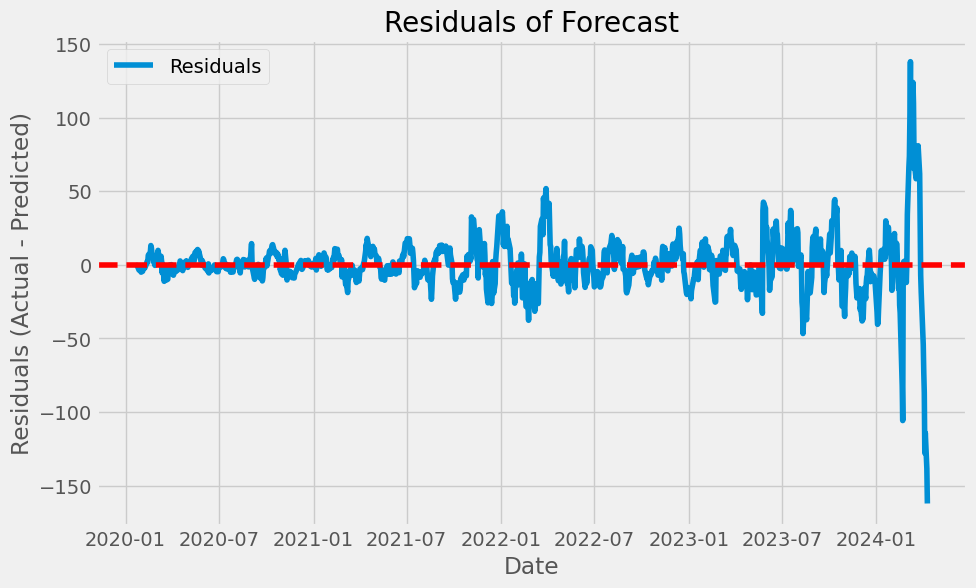

In [160]:
plt.figure(figsize=(10, 6))
plt.plot(merged_box['ds'], merged_box['residuals'], label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Forecast')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

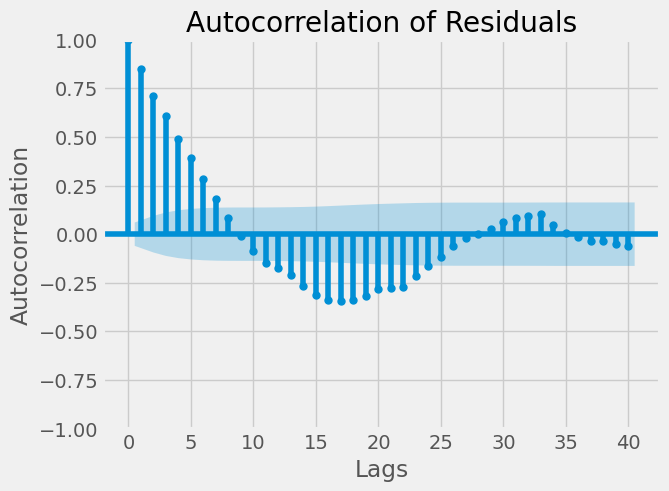

In [161]:
plot_acf(merged_box['residuals'], lags=40, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [162]:
stat, p = shapiro(merged_box['residuals'].dropna())
print('Shapiro-Wilk Test: Stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

Shapiro-Wilk Test: Stat=0.788, p=0.000
Probably not Gaussian


## Add Holidays to seasonality

In [90]:
m = Prophet(interval_width=0.95, weekly_seasonality=True, 
            changepoint_prior_scale=best_params['changepoint_prior_scale'], 
            seasonality_prior_scale=best_params['seasonality_prior_scale'])
m.add_country_holidays(country_name='US')
model = m.fit(nvda_prophet_2020)

21:10:58 - cmdstanpy - INFO - Chain [1] start processing
21:10:58 - cmdstanpy - INFO - Chain [1] done processing


In [91]:
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

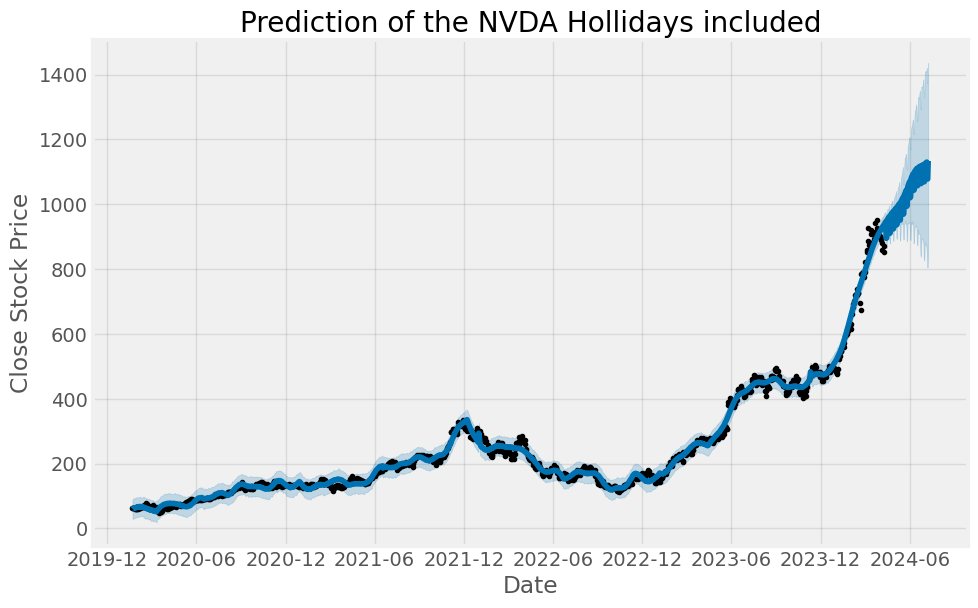

In [92]:
m.plot(forecast)
plt.title("Prediction of the NVDA Hollidays included")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

In [93]:
merged_data_hol = forecast[['ds', 'yhat']].merge(nvda_prophet_2020, on='ds')
merged_data_hol['residuals'] = merged_data_hol['y'] - merged_data_hol['yhat']
merged_data_hol['error'] = np.abs(merged_data_hol['yhat'] - merged_data_hol['y'])
mae_hol = merged_data_hol['error'].mean()

merged_data_hol['percentage_error'] = np.abs((merged_data_hol['yhat'] - merged_data_hol['y']) / merged_data_hol['y'])
mape_hol = merged_data['percentage_error'].mean() * 100

print(f"MAE: {mae_hol}")
print(f"MAPE: {mape_hol}%")

MAE: 11.370572817506343
MAPE: 5.619745253624611%


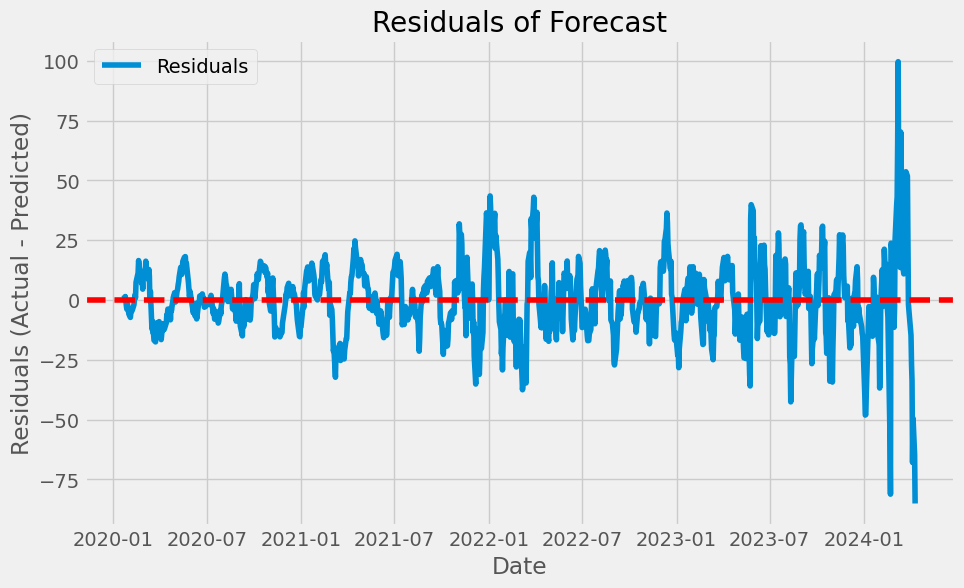

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(merged_data_hol['ds'], merged_data_hol['residuals'], label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Forecast')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

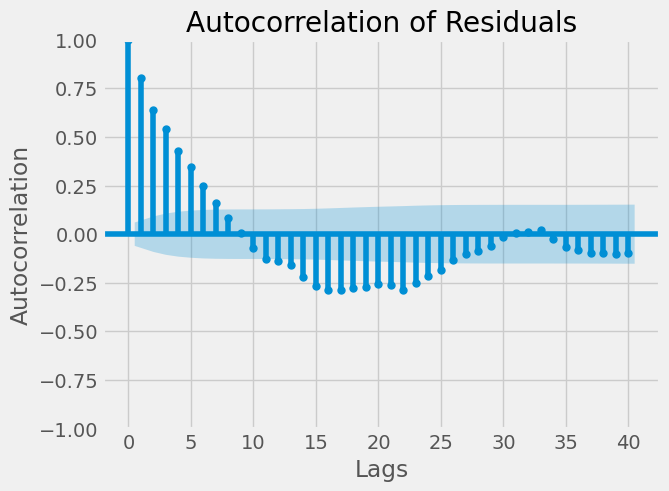

In [97]:
plot_acf(merged_data_hol['residuals'], lags=40, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [110]:
stat, p = shapiro(merged_data_hol['residuals'].dropna())
print('Shapiro-Wilk Test: Stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

Shapiro-Wilk Test: Stat=0.958, p=0.000
Probably not Gaussian


In [108]:
lb_test = acorr_ljungbox(merged_data_hol['residuals'], lags=[10, 20], return_df=True)
lb_test

,lb_stat,lb_pvalue
10,1864.524868,0.0
20,2473.412452,0.0


The significant autocorrelation in the residuals indicates that the Prophet model has not captured all the underlying patterns in the data.